In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import squarify 
import os 
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMModel,LGBMClassifier

# view accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

import matplotlib.pyplot as plt
import zipfile
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
zip_orders_train = "order_products__train.csv"
zip_orders_prior = "order_products__prior.csv"
zip_orders = 'orders.csv'
zip_products = 'products.csv'
zip_departments = 'departments.csv'
zip_aisles = 'aisles.csv'

archive_orders_train = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_orders_train+".zip","r")
archive_orders_prior = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_orders_prior+".zip","r")
archive_orders = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_orders+".zip","r")
archive_products = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_products+".zip","r")
archive_departments = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_departments+".zip","r")
archive_aisles = zipfile.ZipFile("../instacart-market-basket-analysis/"+zip_aisles+".zip","r")

df_order_train = pd.read_csv(archive_orders_train.open('order_products__train.csv'))
df_order_prior = pd.read_csv(archive_orders_prior.open('order_products__prior.csv'))
df_order = pd.read_csv(archive_orders.open('orders.csv'))
df_product = pd.read_csv(archive_products.open('products.csv'))
df_departments = pd.read_csv(archive_departments.open('departments.csv'))
df_aisles = pd.read_csv(archive_aisles.open('aisles.csv'))

Let's explore the dataset.

In [3]:
df_merged = pd.merge(df_product,df_aisles,on='aisle_id')
df_merged = pd.merge(df_merged,df_departments,on='department_id')

In [4]:
del [df_aisles, df_departments]

In [5]:
df_order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
df_order['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [7]:
prior = df_order[df_order['eval_set']=='prior']

In [8]:
prior = pd.merge(prior,df_order_prior,on='order_id')

In [9]:
prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [10]:
df_merged.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


Only the days since prior order has null values.

In [11]:
prior[prior['days_since_prior_order'].isnull()]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434368,3154581,206209,prior,1,3,11,NaN,20073,9,0
32434369,3154581,206209,prior,1,3,11,NaN,13176,10,0
32434370,3154581,206209,prior,1,3,11,NaN,20842,11,0
32434371,3154581,206209,prior,1,3,11,NaN,23594,12,0


All the first orders of a customer are Nan. We can replace this value using 0

In [12]:
prior['days_since_prior_order'] = prior['days_since_prior_order'].fillna(0) 

In [13]:
prior.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
dtype: int64

In [14]:
#Total number of orders placed by each users
users = prior.groupby(by='user_id')['order_number'].aggregate('max').to_frame('u_num_of_orders').reset_index()

In [15]:
users.isnull().sum()

user_id            0
u_num_of_orders    0
dtype: int64

In [16]:
# Average number of products bought by the user in each purchase.
#1. First getting the total number of products in each order.
total_prd_per_order = prior.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('total_products_per_order').reset_index()
total_prd_per_order.head()

,user_id,order_id,total_products_per_order
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6


In [17]:
total_prd_per_order.isnull().sum()

user_id                     0
order_id                    0
total_products_per_order    0
dtype: int64

In [18]:
#2. Getting the average products purchased by each user
avg_products = total_prd_per_order.groupby(by=['user_id'])['total_products_per_order'].mean().to_frame('u_avg_prd').reset_index()

#deleting the total_prd_per_order dataframe
del total_prd_per_order

In [19]:
avg_products.head()

,user_id,u_avg_prd
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [20]:
avg_products.isnull().sum()

user_id      0
u_avg_prd    0
dtype: int64

In [21]:
#dow of most orders placed by each user
from scipy import stats
dow = prior.groupby(by='user_id')['order_dow'].agg(lambda x: stats.mode(x)[0]).to_frame('dow_most_orders_u').reset_index()
dow.head()

,user_id,dow_most_orders_u
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [22]:
hod = prior.groupby(by='user_id')['order_hour_of_day'].agg(lambda x: stats.mode(x)[0]).to_frame('hod_most_orders_u').reset_index()
hod.head()

,user_id,hod_most_orders_u
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [23]:
prior = pd.merge(prior,df_merged,on='product_id')
prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,0.0,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages


In [24]:
prior.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

In [25]:
freq_aisle = prior.groupby(by='user_id')['aisle_id'].agg(lambda x: stats.mode(x)[0]).to_frame('freq_aisle').reset_index()
freq_aisle.head()

,user_id,freq_aisle
0,1,77
1,2,120
2,3,24
3,4,38
4,5,123


In [26]:
freq_department = prior.groupby(by='user_id')['department_id'].agg(lambda x: stats.mode(x)[0]).to_frame('freq_department').reset_index()
freq_department.head()

,user_id,freq_department
0,1,19
1,2,16
2,3,4
3,4,1
4,5,4


In [27]:
#merging avg_products with users
users = users.merge(avg_products, on='user_id', how='left')
#deleting avg_products
del avg_products
users.head()

,user_id,u_num_of_orders,u_avg_prd
0,1,10,5.900000
1,2,14,13.928571
2,3,12,7.333333
3,4,5,3.600000
4,5,4,9.250000


In [28]:
users = users.merge(dow, on='user_id', how='left')
#deleting dow
del dow
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u
0,1,10,5.900000,4
1,2,14,13.928571,2
2,3,12,7.333333,0
3,4,5,3.600000,4
4,5,4,9.250000,3


In [29]:
#3. merging hod with users
users = users.merge(hod, on='user_id', how='left')
#deleting dow
del hod
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,10,5.900000,4,7
1,2,14,13.928571,2,9
2,3,12,7.333333,0,16
3,4,5,3.600000,4,15
4,5,4,9.250000,3,18


In [30]:
#4. merging frequent aisle with users
users = users.merge(freq_aisle, on='user_id', how='left')
#deleting dow
del freq_aisle
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle
0,1,10,5.900000,4,7,77
1,2,14,13.928571,2,9,120
2,3,12,7.333333,0,16,24
3,4,5,3.600000,4,15,38
4,5,4,9.250000,3,18,123


In [31]:
#4. merging frequent aisle with users
users = users.merge(freq_department, on='user_id', how='left')
#deleting dow
del freq_department
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department
0,1,10,5.900000,4,7,77,19
1,2,14,13.928571,2,9,120,16
2,3,12,7.333333,0,16,24,4
3,4,5,3.600000,4,15,38,1
4,5,4,9.250000,3,18,123,4


In [32]:
#number of time a product was purchased.
prd = prior.groupby(by='product_id')['order_id'].agg('count').to_frame('prd_count_p').reset_index()
prd.head()

,product_id,prd_count_p
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [33]:
#products reorder ratio.
reorder_p = prior.groupby(by='product_id')['reordered'].agg('mean').to_frame('p_reordered_ratio').reset_index()
reorder_p.head()

,product_id,p_reordered_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [34]:
#merging the reorder_p with prd
prd = prd.merge(reorder_p, on='product_id', how='left')
#deleting reorder_p
del reorder_p
prd.head()

,product_id,prd_count_p,p_reordered_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [35]:
#how many times a user bought the same product.
uxp = prior.groupby(by=['user_id', 'product_id'])['order_id'].agg('count').to_frame('uxp_times_bought').reset_index()
uxp.head()

,user_id,product_id,uxp_times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [36]:
#reorder ratio of the user for each product.
reorder_uxp = prior.groupby(by=['user_id', 'product_id'])['reordered'].agg('mean').to_frame('uxp_reordered_ratio').reset_index()
reorder_uxp.head()

,user_id,product_id,uxp_reordered_ratio
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667


In [37]:
#merging the two dataframes into one
uxp = uxp.merge(reorder_uxp, on=['user_id', 'product_id'], how='left')
#deleting reorder_uxp
del reorder_uxp
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio
0,1,196,10,0.900000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,10,0.900000
4,1,13032,3,0.666667


In [38]:
#merging users df into uxp
df = uxp.merge(users, on='user_id', how='left')
df.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department
0,1,196,10,0.900000,10,5.9,4,7,77,19
1,1,10258,9,0.888889,10,5.9,4,7,77,19
2,1,10326,1,0.000000,10,5.9,4,7,77,19
3,1,12427,10,0.900000,10,5.9,4,7,77,19
4,1,13032,3,0.666667,10,5.9,4,7,77,19


In [39]:
#merging products df into data
df = df.merge(prd, on='product_id', how='left')
df.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio
0,1,196,10,0.900000,10,5.9,4,7,77,19,35791,0.776480
1,1,10258,9,0.888889,10,5.9,4,7,77,19,1946,0.713772
2,1,10326,1,0.000000,10,5.9,4,7,77,19,5526,0.652009
3,1,12427,10,0.900000,10,5.9,4,7,77,19,6476,0.740735
4,1,13032,3,0.666667,10,5.9,4,7,77,19,3751,0.657158


In [40]:
del [users, prd, uxp]

Creating the training set

In [41]:
#keeping only the train eval set from the orders dataframe.
train = df_order.loc[((df_order.eval_set == 'train')), ['user_id', 'order_id']]
train.head()

,user_id,order_id
10,1,1187899
25,2,1492625
49,5,2196797
74,7,525192
78,8,880375


In [42]:
#merging the order_future with the data.
df = df.merge(train, on='user_id', how='left')
df.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,order_id
0,1,196,10,0.900000,10,5.9,4,7,77,19,35791,0.776480,1187899.0
1,1,10258,9,0.888889,10,5.9,4,7,77,19,1946,0.713772,1187899.0
2,1,10326,1,0.000000,10,5.9,4,7,77,19,5526,0.652009,1187899.0
3,1,12427,10,0.900000,10,5.9,4,7,77,19,6476,0.740735,1187899.0
4,1,13032,3,0.666667,10,5.9,4,7,77,19,3751,0.657158,1187899.0


In [43]:
df.isnull().sum()

user_id                      0
product_id                   0
uxp_times_bought             0
uxp_reordered_ratio          0
u_num_of_orders              0
u_avg_prd                    0
dow_most_orders_u            0
hod_most_orders_u            0
freq_aisle                   0
freq_department              0
prd_count_p                  0
p_reordered_ratio            0
order_id               4833292
dtype: int64

In [44]:
df_order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [45]:
#merging the information from the order_proucts_train df into the data_train.
df = df.merge(df_order_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
df.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,77,19,35791,0.776480,1187899.0,1.0
1,1,10258,9,0.888889,10,5.9,4,7,77,19,1946,0.713772,1187899.0,1.0
2,1,10326,1,0.000000,10,5.9,4,7,77,19,5526,0.652009,1187899.0,NaN
3,1,12427,10,0.900000,10,5.9,4,7,77,19,6476,0.740735,1187899.0,NaN
4,1,13032,3,0.666667,10,5.9,4,7,77,19,3751,0.657158,1187899.0,1.0


In [46]:
df.isnull().sum()

user_id                       0
product_id                    0
uxp_times_bought              0
uxp_reordered_ratio           0
u_num_of_orders               0
u_avg_prd                     0
dow_most_orders_u             0
hod_most_orders_u             0
freq_aisle                    0
freq_department               0
prd_count_p                   0
p_reordered_ratio             0
order_id                4833292
reordered              12479129
dtype: int64

In [47]:
#filling the NAN values
df.reordered.fillna(0, inplace=True)

In [48]:
df.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,77,19,35791,0.776480,1187899.0,1.0
1,1,10258,9,0.888889,10,5.9,4,7,77,19,1946,0.713772,1187899.0,1.0
2,1,10326,1,0.000000,10,5.9,4,7,77,19,5526,0.652009,1187899.0,0.0
3,1,12427,10,0.900000,10,5.9,4,7,77,19,6476,0.740735,1187899.0,0.0
4,1,13032,3,0.666667,10,5.9,4,7,77,19,3751,0.657158,1187899.0,1.0


In [49]:
#setting user_id and product_id as index.
order_id = df[['user_id', 'product_id','order_id']]

#deleting eval_set, order_id as they are not needed for training.
df.drop(['order_id'], axis=1, inplace=True)
df = df.set_index(['user_id', 'product_id'])

In [50]:
df.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
1       196                       10             0.900000               10   
        10258                      9             0.888889               10   
        10326                      1             0.000000               10   
        12427                     10             0.900000               10   
        13032                      3             0.666667               10   

                    u_avg_prd  dow_most_orders_u  hod_most_orders_u  \
user_id product_id                                                    
1       196               5.9                  4                  7   
        10258             5.9                  4                  7   
        10326             5.9                  4                  7   
        12427             5.9                  4                  7   
        13032             5.9                  4                  7   

                    freq_aisle  freq_department  prd_count_p  \
user_id product_id                                             
1       196                 77               19        35791   
        10258               77               19         1946   
        10326               77               19         5526   
        12427               77               19         6476   
        13032               77               19         3751   

                    p_reordered_ratio  reordered  
user_id product_id                                
1       196                  0.776480        1.0  
        10258                0.713772        1.0  
        10326                0.652009        0.0  
        12427                0.740735        0.0  
        13032                0.657158        1.0

In [51]:
y = df.reordered
X = df.drop(columns=['reordered'])

In [52]:
# X_1 = X.reset_index()

In [53]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X_1, y)
# X_resampled = X_resampled.set_index(['user_id', 'product_id'])

In [54]:
#Split in 75% train and 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(X_train, label=y_train)

#Select Hyper-Parameters
parameters = {
              'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#               'feature_fraction': [0.6, 0.8,0.95],
              'bagging_fraction': [0.6,  0.8,  0.95],
#               'bagging_freq': [2, 4, 5, 6, 8],
#               'lambda_l1': [0, 0.1, 0.5],
#               'lambda_l2': [0, 10, 15],
#               'cat_smooth': [1, 10, 15,]
}
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'log-loss',
                         learning_rate = 0.01,
                         num_leaves = 128,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0)
 # With gridsearch we don't need the fit function
    
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=5, verbose=100)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5; 1/75] START bagging_fraction=0.6, learning_rate=0.01, max_depth=15.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 1/75] END bagging_fraction=0.6, learning_rate=0.01, max_depth=15; total time= 1.4min
[CV 2/5; 1/75] START bagging_fraction=0.6, learning_rate=0.01, max_depth=15.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[Light

[CV 2/5; 3/75] END bagging_fraction=0.6, learning_rate=0.01, max_depth=25; total time= 1.3min
[CV 3/5; 3/75] START bagging_fraction=0.6, learning_rate=0.01, max_depth=25.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 3/75] END bagging_fraction=0.6, learning_rate=0.01, max_depth=25; total time= 1.3min
[CV 4/5; 3/75] START bagging_fraction=0.6, learning_rate=0.01, max_depth=25.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 4/5; 5/75] END bagging_fraction=0.6, learning_rate=0.01, max_depth=35; total time= 1.3min
[CV 5/5; 5/75] START bagging_fraction=0.6, learning_rate=0.01, max_depth=35.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 5/75] END bagging_fraction=0.6, learning_rate=0.01, max_depth=35; total time= 1.3min
[CV 1/5; 6/75] START bagging_fraction=0.6, learning_rate=0.02, max_depth=15.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 1/5; 8/75] END bagging_fraction=0.6, learning_rate=0.02, max_depth=25; total time= 1.2min
[CV 2/5; 8/75] START bagging_fraction=0.6, learning_rate=0.02, max_depth=25.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 8/75] END bagging_fraction=0.6, learning_rate=0.02, max_depth=25; total time= 1.2min
[CV 3/5; 8/75] START bagging_fraction=0.6, learning_rate=0.02, max_depth=25.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 3/5; 10/75] END bagging_fraction=0.6, learning_rate=0.02, max_depth=35; total time= 1.1min
[CV 4/5; 10/75] START bagging_fraction=0.6, learning_rate=0.02, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 10/75] END bagging_fraction=0.6, learning_rate=0.02, max_depth=35; total time= 1.2min
[CV 5/5; 10/75] START bagging_fraction=0.6, learning_rate=0.02, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 5/5; 12/75] END bagging_fraction=0.6, learning_rate=0.05, max_depth=20; total time= 1.1min
[CV 1/5; 13/75] START bagging_fraction=0.6, learning_rate=0.05, max_depth=25....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 13/75] END bagging_fraction=0.6, learning_rate=0.05, max_depth=25; total time= 1.1min
[CV 2/5; 13/75] START bagging_fraction=0.6, learning_rate=0.05, max_depth=25....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 2/5; 15/75] END bagging_fraction=0.6, learning_rate=0.05, max_depth=35; total time=  58.2s
[CV 3/5; 15/75] START bagging_fraction=0.6, learning_rate=0.05, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 15/75] END bagging_fraction=0.6, learning_rate=0.05, max_depth=35; total time=  58.8s
[CV 4/5; 15/75] START bagging_fraction=0.6, learning_rate=0.05, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 4/5; 17/75] END bagging_fraction=0.6, learning_rate=0.1, max_depth=20; total time=  50.7s
[CV 5/5; 17/75] START bagging_fraction=0.6, learning_rate=0.1, max_depth=20.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 17/75] END bagging_fraction=0.6, learning_rate=0.1, max_depth=20; total time=  47.0s
[CV 1/5; 18/75] START bagging_fraction=0.6, learning_rate=0.1, max_depth=25.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 1/5; 20/75] END bagging_fraction=0.6, learning_rate=0.1, max_depth=35; total time=  46.7s
[CV 2/5; 20/75] START bagging_fraction=0.6, learning_rate=0.1, max_depth=35.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 20/75] END bagging_fraction=0.6, learning_rate=0.1, max_depth=35; total time=  48.4s
[CV 3/5; 20/75] START bagging_fraction=0.6, learning_rate=0.1, max_depth=35.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 3/5; 22/75] END bagging_fraction=0.6, learning_rate=0.15, max_depth=20; total time=  43.8s
[CV 4/5; 22/75] START bagging_fraction=0.6, learning_rate=0.15, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 22/75] END bagging_fraction=0.6, learning_rate=0.15, max_depth=20; total time=  44.0s
[CV 5/5; 22/75] START bagging_fraction=0.6, learning_rate=0.15, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 5/5; 24/75] END bagging_fraction=0.6, learning_rate=0.15, max_depth=30; total time=  41.3s
[CV 1/5; 25/75] START bagging_fraction=0.6, learning_rate=0.15, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 25/75] END bagging_fraction=0.6, learning_rate=0.15, max_depth=35; total time=  40.5s
[CV 2/5; 25/75] START bagging_fraction=0.6, learning_rate=0.15, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 2/5; 27/75] END bagging_fraction=0.8, learning_rate=0.01, max_depth=20; total time= 2.1min
[CV 3/5; 27/75] START bagging_fraction=0.8, learning_rate=0.01, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 27/75] END bagging_fraction=0.8, learning_rate=0.01, max_depth=20; total time= 1.9min
[CV 4/5; 27/75] START bagging_fraction=0.8, learning_rate=0.01, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 4/5; 29/75] END bagging_fraction=0.8, learning_rate=0.01, max_depth=30; total time= 1.9min
[CV 5/5; 29/75] START bagging_fraction=0.8, learning_rate=0.01, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 29/75] END bagging_fraction=0.8, learning_rate=0.01, max_depth=30; total time= 1.8min
[CV 1/5; 30/75] START bagging_fraction=0.8, learning_rate=0.01, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 1/5; 32/75] END bagging_fraction=0.8, learning_rate=0.02, max_depth=20; total time= 1.3min
[CV 2/5; 32/75] START bagging_fraction=0.8, learning_rate=0.02, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 32/75] END bagging_fraction=0.8, learning_rate=0.02, max_depth=20; total time= 1.3min
[CV 3/5; 32/75] START bagging_fraction=0.8, learning_rate=0.02, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 3/5; 34/75] END bagging_fraction=0.8, learning_rate=0.02, max_depth=30; total time= 1.3min
[CV 4/5; 34/75] START bagging_fraction=0.8, learning_rate=0.02, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 34/75] END bagging_fraction=0.8, learning_rate=0.02, max_depth=30; total time= 1.3min
[CV 5/5; 34/75] START bagging_fraction=0.8, learning_rate=0.02, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 5/5; 36/75] END bagging_fraction=0.8, learning_rate=0.05, max_depth=15; total time= 1.2min
[CV 1/5; 37/75] START bagging_fraction=0.8, learning_rate=0.05, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 37/75] END bagging_fraction=0.8, learning_rate=0.05, max_depth=20; total time= 1.2min
[CV 2/5; 37/75] START bagging_fraction=0.8, learning_rate=0.05, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 2/5; 39/75] END bagging_fraction=0.8, learning_rate=0.05, max_depth=30; total time= 1.2min
[CV 3/5; 39/75] START bagging_fraction=0.8, learning_rate=0.05, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 39/75] END bagging_fraction=0.8, learning_rate=0.05, max_depth=30; total time= 1.2min
[CV 4/5; 39/75] START bagging_fraction=0.8, learning_rate=0.05, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 4/5; 41/75] END bagging_fraction=0.8, learning_rate=0.1, max_depth=15; total time=  54.0s
[CV 5/5; 41/75] START bagging_fraction=0.8, learning_rate=0.1, max_depth=15.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 41/75] END bagging_fraction=0.8, learning_rate=0.1, max_depth=15; total time=  54.7s
[CV 1/5; 42/75] START bagging_fraction=0.8, learning_rate=0.1, max_depth=20.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 1/5; 44/75] END bagging_fraction=0.8, learning_rate=0.1, max_depth=30; total time=  53.3s
[CV 2/5; 44/75] START bagging_fraction=0.8, learning_rate=0.1, max_depth=30.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 44/75] END bagging_fraction=0.8, learning_rate=0.1, max_depth=30; total time=  54.4s
[CV 3/5; 44/75] START bagging_fraction=0.8, learning_rate=0.1, max_depth=30.....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current va

[CV 3/5; 46/75] END bagging_fraction=0.8, learning_rate=0.15, max_depth=15; total time=  46.4s
[CV 4/5; 46/75] START bagging_fraction=0.8, learning_rate=0.15, max_depth=15....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 46/75] END bagging_fraction=0.8, learning_rate=0.15, max_depth=15; total time=  45.6s
[CV 5/5; 46/75] START bagging_fraction=0.8, learning_rate=0.15, max_depth=15....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 5/5; 48/75] END bagging_fraction=0.8, learning_rate=0.15, max_depth=25; total time=  45.6s
[CV 1/5; 49/75] START bagging_fraction=0.8, learning_rate=0.15, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 49/75] END bagging_fraction=0.8, learning_rate=0.15, max_depth=30; total time=  45.6s
[CV 2/5; 49/75] START bagging_fraction=0.8, learning_rate=0.15, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

[CV 2/5; 51/75] END bagging_fraction=0.95, learning_rate=0.01, max_depth=15; total time= 1.5min
[CV 3/5; 51/75] START bagging_fraction=0.95, learning_rate=0.01, max_depth=15...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 51/75] END bagging_fraction=0.95, learning_rate=0.01, max_depth=15; total time= 1.5min
[CV 4/5; 51/75] START bagging_fraction=0.95, learning_rate=0.01, max_depth=15...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 53/75] END bagging_fraction=0.95, learning_rate=0.01, max_depth=25; total time= 1.5min
[CV 5/5; 53/75] START bagging_fraction=0.95, learning_rate=0.01, max_depth=25...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is s

[CV 5/5; 55/75] END bagging_fraction=0.95, learning_rate=0.01, max_depth=35; total time= 1.5min
[CV 1/5; 56/75] START bagging_fraction=0.95, learning_rate=0.02, max_depth=15...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 56/75] END bagging_fraction=0.95, learning_rate=0.02, max_depth=15; total time= 1.5min
[CV 2/5; 56/75] START bagging_fraction=0.95, learning_rate=0.02, max_depth=15...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 58/75] END bagging_fraction=0.95, learning_rate=0.02, max_depth=25; total time= 1.5min
[CV 3/5; 58/75] START bagging_fraction=0.95, learning_rate=0.02, max_depth=25...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is s

[CV 3/5; 60/75] END bagging_fraction=0.95, learning_rate=0.02, max_depth=35; total time= 1.5min
[CV 4/5; 60/75] START bagging_fraction=0.95, learning_rate=0.02, max_depth=35...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 4/5; 60/75] END bagging_fraction=0.95, learning_rate=0.02, max_depth=35; total time= 1.5min
[CV 5/5; 60/75] START bagging_fraction=0.95, learning_rate=0.02, max_depth=35...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 62/75] END bagging_fraction=0.95, learning_rate=0.05, max_depth=20; total time= 1.3min
[CV 1/5; 63/75] START bagging_fraction=0.95, learning_rate=0.05, max_depth=25...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is s

[CV 1/5; 65/75] END bagging_fraction=0.95, learning_rate=0.05, max_depth=35; total time= 1.3min
[CV 2/5; 65/75] START bagging_fraction=0.95, learning_rate=0.05, max_depth=35...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 2/5; 65/75] END bagging_fraction=0.95, learning_rate=0.05, max_depth=35; total time= 1.3min
[CV 3/5; 65/75] START bagging_fraction=0.95, learning_rate=0.05, max_depth=35...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 67/75] END bagging_fraction=0.95, learning_rate=0.1, max_depth=20; total time=  59.9s
[CV 4/5; 67/75] START bagging_fraction=0.95, learning_rate=0.1, max_depth=20....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is se

[CV 4/5; 69/75] END bagging_fraction=0.95, learning_rate=0.1, max_depth=30; total time=  59.0s
[CV 5/5; 69/75] START bagging_fraction=0.95, learning_rate=0.1, max_depth=30....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 5/5; 69/75] END bagging_fraction=0.95, learning_rate=0.1, max_depth=30; total time=  59.3s
[CV 1/5; 70/75] START bagging_fraction=0.95, learning_rate=0.1, max_depth=35....
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 1/5; 72/75] END bagging_fraction=0.95, learning_rate=0.15, max_depth=20; total time=  50.2s
[CV 2/5; 72/75] START bagging_fraction=0.95, learning_rate=0.15, max_depth=20...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is s

[CV 2/5; 74/75] END bagging_fraction=0.95, learning_rate=0.15, max_depth=30; total time=  49.9s
[CV 3/5; 74/75] START bagging_fraction=0.95, learning_rate=0.15, max_depth=30...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV 3/5; 74/75] END bagging_fraction=0.95, learning_rate=0.15, max_depth=30; total time=  49.9s
[CV 4/5; 74/75] START bagging_fraction=0.95, learning_rate=0.15, max_depth=30...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Curr

GridSearchCV(cv=5,
             estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=8,
                                      feature_fraction=0.8, lambda_l1=0.6,
                                      lambda_l2=0, learning_rate=0.01,
                                      metric='log-loss', num_leaves=128,
                                      objective='binary'),
             param_grid={'bagging_fraction': [0.6, 0.8, 0.95],
                         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
                         'max_depth': [15, 20, 25, 30, 35]},
             scoring='roc_auc', verbose=100)

In [55]:
# Print the best parameters found
print(gsearch.best_params_)
print(gsearch.best_score_)

{'bagging_fraction': 0.95, 'learning_rate': 0.15, 'max_depth': 30}
0.7886372851183305


In [56]:
# Using parameters already set above, replace in the best from the grid search
# params['max_delta_step'] = grid.best_params_['max_delta_step']
parameters['max_depth'] = gsearch.best_params_['max_depth']
parameters['learning_rate'] = gsearch.best_params_['learning_rate']
# params['feature_fraction'] = gsearch.best_params_['feature_fraction']
parameters['bagging_fraction'] = gsearch.best_params_['bagging_fraction']
# params['lambda_l1'] = gsearch.best_params_['lambda_l1']
# params['lambda_l2'] = gsearch.best_params_['lambda_l2']
# params['cat_smooth'] = gsearch.best_params_['cat_smooth']

print('Fitting with params: ')
print(parameters)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(parameters,
                 d_train,
                 10000,
                 verbose_eval= 100,
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test)

Fitting with params: 
{'max_depth': 30, 'learning_rate': 0.15, 'bagging_fraction': 0.95}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.371883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 9980964, number of used features: 10
[LightGBM] [Info] Start training from score 0.062259


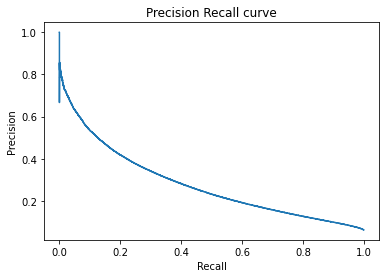

In [106]:
#--------------------------Print precision recall curve----------------------

from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, predictions_lgbm_prob)

plt.figure()
plt.step(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve');
plt.show()

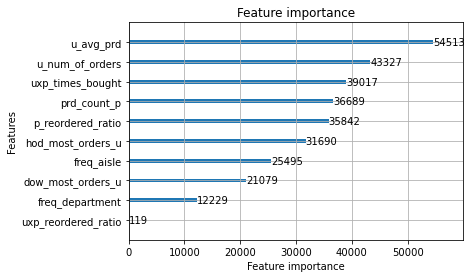

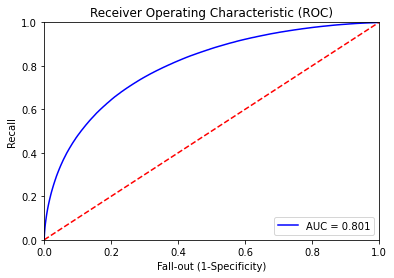

AUC score: 0.8014125518899021


In [107]:
#--------------------------Print accuracy measures and variable importances----------------------

#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

# #Print accuracy
# acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
# print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

In [108]:
X_test['prediction_prob'] = predictions_lgbm_prob

In [109]:
X_test_predict = X_test
X_test_predict.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,prediction_prob
0,163834,26283,3,0.666667,15,7.333333,0,12,83,4,18906,0.583148,0.067424
1,125629,28204,2,0.500000,11,18.272727,0,13,83,4,89632,0.711922,0.072709
2,182247,14183,3,0.666667,4,8.000000,0,15,24,4,2794,0.614889,0.250896
3,174134,20169,1,0.000000,13,16.307692,5,10,24,4,3054,0.527505,0.027878
4,107989,14429,1,0.000000,51,12.431373,1,13,24,4,2761,0.228178,0.004007


In [110]:
X_test_predict.reset_index(inplace=True)

In [111]:
X_test_predict.head()

,index,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,prediction_prob
0,0,163834,26283,3,0.666667,15,7.333333,0,12,83,4,18906,0.583148,0.067424
1,1,125629,28204,2,0.500000,11,18.272727,0,13,83,4,89632,0.711922,0.072709
2,2,182247,14183,3,0.666667,4,8.000000,0,15,24,4,2794,0.614889,0.250896
3,3,174134,20169,1,0.000000,13,16.307692,5,10,24,4,3054,0.527505,0.027878
4,4,107989,14429,1,0.000000,51,12.431373,1,13,24,4,2761,0.228178,0.004007


In [112]:
top_5_per_user = X_test_predict.groupby('user_id').apply(lambda x: x.nlargest(5,'prediction_prob')).reset_index(level=0, drop=True)

In [113]:
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_test, predictions_lgbm_prob)
print(lr_auc)

0.8014125518899021


In [114]:
yhat = predictions_lgbm_prob

## Threshold tuning using Gmeans

Best Threshold=0.062938, G-Mean=0.726


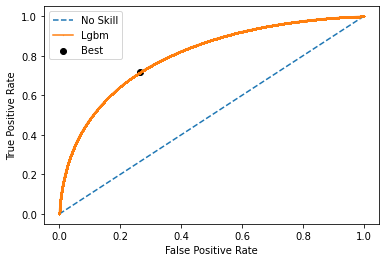

In [122]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.',markersize=0.5, label='Lgbm')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()


# precision, recall, new_thresholds = precision_recall_curve(y_test, yhat)
# # convert to f score
# no_skill = len(y_test[y_test==1]) / len(y_test)
# plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
# plt.plot(recall, precision, label='Lgbm')
# plt.plot(recall[:-1],new_thresholds, marker="",label='Lgbm')
# plt.scatter(recall, precision, marker='o', color='black', label='Best')
# # axis labels
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# # show the plot
# plt.show()

In [116]:
#using this threshold our new f1-score 
predictions_lgbm_01 = np.where(predictions_lgbm_prob > thresholds[ix], 1, 0) #Turn probability to 0-1 binary output
print("F1-score:=%.3f" % (f1_score(y_test, predictions_lgbm_01,average='macro')))
print("ROC-AUC score:=%.3f" % (roc_auc_score(y_test,predictions_lgbm_01)))

F1-score:=0.544
ROC-AUC score:=0.726


In [117]:
b = top_5_per_user.reset_index(drop=True)
b.head()

,index,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,freq_aisle,freq_department,prd_count_p,p_reordered_ratio,prediction_prob
0,2572666,1,12427,10,0.9,10,5.9,4,7,77,19,6476,0.740735,0.791469
1,2906027,1,196,10,0.9,10,5.9,4,7,77,19,35791,0.776480,0.686389
2,1422530,1,10326,1,0.0,10,5.9,4,7,77,19,5526,0.652009,0.159097
3,951759,1,38928,1,0.0,10,5.9,4,7,77,19,13238,0.827769,0.127618
4,820163,1,49235,2,0.5,10,5.9,4,7,77,19,76360,0.781456,0.125307


5    83.339985
4     4.846442
3     4.566575
2     4.088139
1     3.158859
Name: prediction_01, dtype: float64


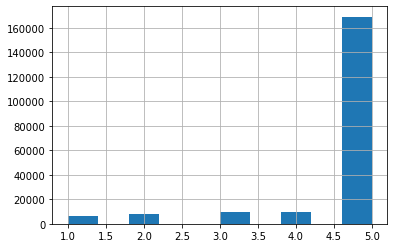

In [118]:
b['prediction_01'] = np.where(b.prediction_prob > thresholds[ix], 1, 0) #Turn probability to 0-1 binary output
print(b.groupby('user_id')['prediction_01'].count().value_counts(normalize=True).mul(100))
b.groupby('user_id')['prediction_01'].count().hist()

In [119]:
import joblib
import pickle
joblib.dump(lgbm, 'model_version1.1.pkl', compress = 1)

['model_version1.1.pkl']